<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab12_SAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12: Soft Actor Critic

Train a Soft Actor-Critic (SAC) agent on HalfCheetah-v4,
track its learning curve, and compare the result with your previous RL algorithm.

We will learn to use the **stable_baselines3** library


## To start
Run the following code that solves **the Pendulum problem**

In [1]:
# Install dependencies
%pip install "stable-baselines3[extra]" "gymnasium[classic_control]"

Note: you may need to restart the kernel to use updated packages.


The following code trains a full SAC agent — with two critics, entropy tuning, and replay buffer — out of the box

In [2]:
import gymnasium as gym
from stable_baselines3 import SAC

# Create environment
env = gym.make("Pendulum-v1")

# Create SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Train the agent with N time steps
N = 4000
model.learn(total_timesteps=N)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 200       |
|    ep_rew_mean     | -1.26e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 213       |
|    time_elapsed    | 3         |
|    total_timesteps | 800       |
| train/             |           |
|    actor_loss      | 19.6      |
|    critic_loss     | 0.193     |
|    ent_coef        | 0.813     |
|    ent_coef_loss   | -0.326    |
|    learning_rate   | 0.0003    |
|    n_updates       | 699       |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -1.4e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 212      |
|    time_elapsed    | 7        |
|    total_timesteps | 1600     |
| tr

# Visualize the result

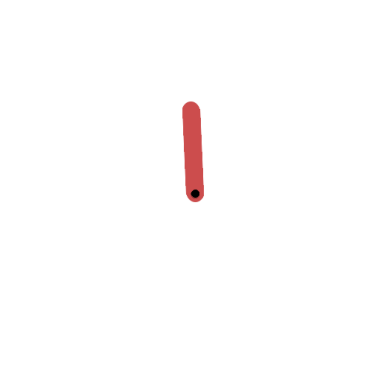

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make("Pendulum-v1", render_mode="rgb_array")
obs, _ = env.reset()

fig, ax = plt.subplots()
frame = env.render()
img = ax.imshow(frame)
plt.axis("off")

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    frame = env.render()
    img.set_data(frame)

    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

    if done or truncated:
        obs, _ = env.reset()

env.close()
plt.close()


## Exercise 1: Soft Actor-Critic on HalfCheetah
**Goal:**
Adapt the existing Soft Actor-Critic (SAC) implementation from the Pendulum-v1 environment to train and evaluate a SAC agent on the more challenging HalfCheetah-v4 task.

### Instructions

1. Adapt your code: Modify your previous SAC implementation so that it runs on the HalfCheetah-v4 environment from MuJoCo.

2. Reward Logger:
Implement a custom RewardLogger callback to record episode rewards during training (you will have to search online about how to create a class for logger).
After training, use the logged data to plot the learning curve (episode reward vs. timesteps).

3. Experimentation:
    * Compare the performance of SAC on HalfCheetah-v4 with your previous algorithm.
    * Adjust the entropy temperature parameter (ent_coef or target_entropy) and observe how this affects: Exploration behavior, Convergence speed, and Final performance.

Answer the following questions
1. Did SAC reach a higher average reward or converge faster than your previous method?

2. How did changing the temperature for entropy affect the performance and stability of learning?

3. Describe any differences you observed in exploration or motion behavior of the agent.


### Deliverables

* Python notebook or script containing:
    * The adapted SAC training code
    * The RewardLogger implementation
    * Learning curve plots for SAC and your previous algorithm
    * Comparison of different entropy temperature settings

* The answer of the questions above

In [4]:
%pip install gymnasium[mujoco]

Note: you may need to restart the kernel to use updated packages.


# Training

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import SAC, PPO
from stable_baselines3.common.callbacks import BaseCallback


N_steps = 6000_000

# -------- 1) Custom reward logger callback --------
class RewardLoggerCallback(BaseCallback):
    """
    Logs episode rewards during training.
    For each episode, we store:
      - total episode reward
      - global timestep at which the episode ended
    """
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_timesteps = []

    def _on_training_start(self) -> None:
        # One accumulator per environment (works for VecEnvs too)
        n_envs = self.training_env.num_envs
        self._current_rewards = np.zeros(n_envs, dtype=np.float64)

    def _on_step(self) -> bool:
        rewards = self.locals["rewards"]   # shape (n_envs,)
        dones   = self.locals["dones"]     # shape (n_envs,)

        # accumulate rewards
        self._current_rewards += rewards

        # when an env is done, log and reset its accumulator
        for i, done in enumerate(dones):
            if done:
                self.episode_rewards.append(self._current_rewards[i])
                self.episode_timesteps.append(self.num_timesteps)
                self._current_rewards[i] = 0.0

        return True  # continue training


# -------- 2) Create env, model, and train with callback --------
env = gym.make("HalfCheetah-v5")  # no render needed for training
model = PPO("MlpPolicy", env, verbose=1)

reward_logger = RewardLoggerCallback()

# adjust total_timesteps as you like
model.learn(total_timesteps=N_steps, callback=reward_logger, progress_bar=True)

# Save the agent
model.save(f"PPO_{N_steps}")

env.close()


# -------- 3) Plot learning curve: episode reward vs timesteps --------
plt.figure(figsize=(12, 8))
plt.plot(reward_logger.episode_timesteps,
         reward_logger.episode_rewards,
         marker="o", linestyle="-", linewidth=1)

plt.xlabel("Timesteps")
plt.ylabel("Episode reward")
plt.title("PPO on HalfCheetah-v5 - Episode reward vs. timesteps")
plt.grid(True)
plt.tight_layout()
plt.show()


# TEST

In [30]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make("HalfCheetah-v5", render_mode="rgb_array")
obs, _ = env.reset()

fig, ax = plt.subplots()
frame = env.render()
img = ax.imshow(frame)
plt.axis("off")

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    frame = env.render()
    img.set_data(frame)

    clear_output(wait=True)
    display(fig)
    plt.pause(0.01)

    if done or truncated:
        obs, _ = env.reset()

env.close()
plt.close()


KeyboardInterrupt: 

# PART 3